# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

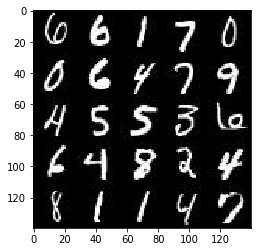

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

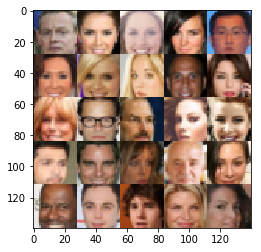

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input conv layer
        c1 = tf.layers.conv2d(images, 64, 5, 2, padding='same')
        r1 = tf.maximum(0.2 * c1, c1)
        
        #1st hidden conv layer
        c2 = tf.layers.conv2d(r1, 128, 5, 2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(c2, training=True)
        r2 = tf.maximum(0.2 * batch_norm2, batch_norm2)

        #2nd hidden conv layer
        c3 = tf.layers.conv2d(r2, 256, 5, 2, padding='same')
        batch_norm3 = tf.layers.batch_normalization(c3, training=True)

        r3 = tf.maximum(0.2 * batch_norm3, batch_norm3)

        flatten = tf.contrib.layers.flatten(r3)  
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First layer - fully connected
        l1 = tf.layers.dense(z, 7*7*512)
        
        # reshape for CNN
        l1 = tf.reshape(l1, (-1,7,7,512))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(0.2 * l1, l1)
        
        l2 = tf.layers.conv2d_transpose(l1, 256, 5, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training = is_train)
        l2 = tf.maximum(0.2 * l2, l2)
        
        # output layer
        logits = tf.layers.conv2d_transpose(l2, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps=0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,input_z: batch_z,lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,input_z: batch_z,lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.2700... Generator Loss: 0.0812
Epoch 1/2... Discriminator Loss: 2.7515... Generator Loss: 0.0974
Epoch 1/2... Discriminator Loss: 2.2283... Generator Loss: 0.3172
Epoch 1/2... Discriminator Loss: 2.1506... Generator Loss: 0.1870
Epoch 1/2... Discriminator Loss: 1.8234... Generator Loss: 0.3791
Epoch 1/2... Discriminator Loss: 1.8142... Generator Loss: 0.4828
Epoch 1/2... Discriminator Loss: 1.7262... Generator Loss: 0.5060
Epoch 1/2... Discriminator Loss: 1.6642... Generator Loss: 0.4646
Epoch 1/2... Discriminator Loss: 1.6525... Generator Loss: 0.7416
Epoch 1/2... Discriminator Loss: 1.6572... Generator Loss: 0.2914


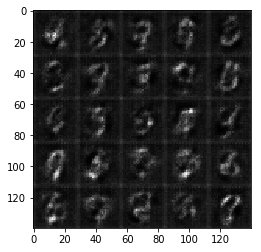

Epoch 1/2... Discriminator Loss: 1.5847... Generator Loss: 0.4573
Epoch 1/2... Discriminator Loss: 1.4839... Generator Loss: 0.7394
Epoch 1/2... Discriminator Loss: 1.5062... Generator Loss: 0.6150
Epoch 1/2... Discriminator Loss: 1.5707... Generator Loss: 1.0126
Epoch 1/2... Discriminator Loss: 1.3388... Generator Loss: 0.8789
Epoch 1/2... Discriminator Loss: 1.3713... Generator Loss: 0.9140
Epoch 1/2... Discriminator Loss: 1.5162... Generator Loss: 0.3560
Epoch 1/2... Discriminator Loss: 1.3050... Generator Loss: 0.7837
Epoch 1/2... Discriminator Loss: 1.6212... Generator Loss: 0.2937
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.4550


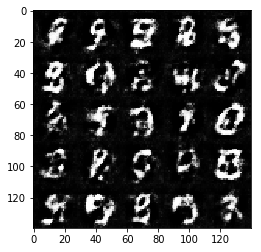

Epoch 1/2... Discriminator Loss: 1.2200... Generator Loss: 1.0332
Epoch 1/2... Discriminator Loss: 1.7014... Generator Loss: 0.2570
Epoch 1/2... Discriminator Loss: 1.2459... Generator Loss: 0.8499
Epoch 1/2... Discriminator Loss: 1.4663... Generator Loss: 0.3862
Epoch 1/2... Discriminator Loss: 1.3730... Generator Loss: 0.6562
Epoch 1/2... Discriminator Loss: 1.5333... Generator Loss: 0.3310
Epoch 1/2... Discriminator Loss: 2.1194... Generator Loss: 0.1574
Epoch 1/2... Discriminator Loss: 1.4885... Generator Loss: 1.0468
Epoch 1/2... Discriminator Loss: 1.4241... Generator Loss: 0.3894
Epoch 1/2... Discriminator Loss: 1.7301... Generator Loss: 0.2463


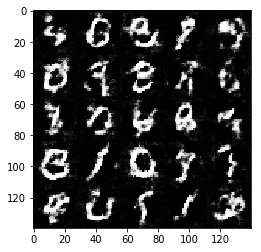

Epoch 1/2... Discriminator Loss: 1.3939... Generator Loss: 0.6911
Epoch 1/2... Discriminator Loss: 1.4523... Generator Loss: 0.4381
Epoch 1/2... Discriminator Loss: 1.4081... Generator Loss: 0.5032
Epoch 1/2... Discriminator Loss: 1.4935... Generator Loss: 0.4542
Epoch 1/2... Discriminator Loss: 1.5177... Generator Loss: 1.0104
Epoch 1/2... Discriminator Loss: 1.6289... Generator Loss: 0.2895
Epoch 1/2... Discriminator Loss: 1.4884... Generator Loss: 0.3972
Epoch 1/2... Discriminator Loss: 1.5502... Generator Loss: 0.3673
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 0.7424
Epoch 1/2... Discriminator Loss: 1.3190... Generator Loss: 0.8217


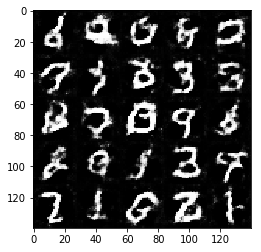

Epoch 1/2... Discriminator Loss: 1.4807... Generator Loss: 0.8461
Epoch 1/2... Discriminator Loss: 1.4430... Generator Loss: 0.5672
Epoch 1/2... Discriminator Loss: 1.5796... Generator Loss: 1.1237
Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 0.4130
Epoch 1/2... Discriminator Loss: 1.4114... Generator Loss: 0.4667
Epoch 1/2... Discriminator Loss: 1.4782... Generator Loss: 0.7417
Epoch 1/2... Discriminator Loss: 1.5176... Generator Loss: 0.3800
Epoch 1/2... Discriminator Loss: 1.5661... Generator Loss: 0.3224
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.5316
Epoch 1/2... Discriminator Loss: 1.3350... Generator Loss: 0.6336


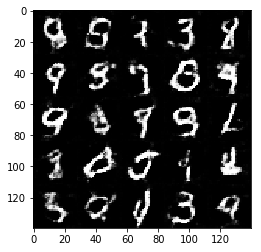

Epoch 1/2... Discriminator Loss: 1.6463... Generator Loss: 0.2914
Epoch 1/2... Discriminator Loss: 1.4137... Generator Loss: 0.9271
Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 0.6234
Epoch 1/2... Discriminator Loss: 1.2996... Generator Loss: 0.5807
Epoch 1/2... Discriminator Loss: 1.3286... Generator Loss: 0.5483
Epoch 1/2... Discriminator Loss: 1.3444... Generator Loss: 0.8912
Epoch 1/2... Discriminator Loss: 1.2115... Generator Loss: 0.6860
Epoch 1/2... Discriminator Loss: 1.3708... Generator Loss: 0.6934
Epoch 1/2... Discriminator Loss: 1.3886... Generator Loss: 1.0006
Epoch 1/2... Discriminator Loss: 1.2140... Generator Loss: 0.6449


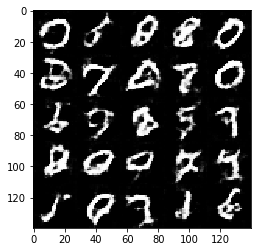

Epoch 1/2... Discriminator Loss: 1.3052... Generator Loss: 0.8600
Epoch 1/2... Discriminator Loss: 1.7098... Generator Loss: 0.2539
Epoch 1/2... Discriminator Loss: 1.8527... Generator Loss: 0.2180
Epoch 1/2... Discriminator Loss: 1.2882... Generator Loss: 0.6299
Epoch 1/2... Discriminator Loss: 1.2975... Generator Loss: 0.6222
Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 0.9254
Epoch 1/2... Discriminator Loss: 1.2394... Generator Loss: 0.6146
Epoch 1/2... Discriminator Loss: 1.8688... Generator Loss: 1.4719
Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 0.5515
Epoch 1/2... Discriminator Loss: 1.2545... Generator Loss: 0.7954


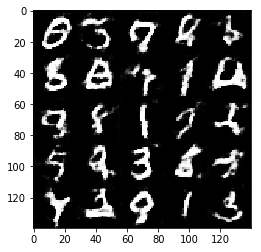

Epoch 1/2... Discriminator Loss: 1.2540... Generator Loss: 0.6136
Epoch 1/2... Discriminator Loss: 1.2562... Generator Loss: 0.6904
Epoch 1/2... Discriminator Loss: 1.2738... Generator Loss: 0.5969
Epoch 1/2... Discriminator Loss: 1.2191... Generator Loss: 0.6256
Epoch 1/2... Discriminator Loss: 1.2531... Generator Loss: 0.6246
Epoch 1/2... Discriminator Loss: 1.1367... Generator Loss: 0.6359
Epoch 1/2... Discriminator Loss: 1.5349... Generator Loss: 0.3658
Epoch 1/2... Discriminator Loss: 1.6882... Generator Loss: 0.2650
Epoch 1/2... Discriminator Loss: 1.3342... Generator Loss: 0.4414
Epoch 1/2... Discriminator Loss: 1.9253... Generator Loss: 0.2030


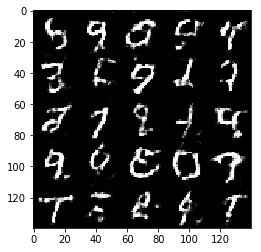

Epoch 1/2... Discriminator Loss: 1.4374... Generator Loss: 0.3883
Epoch 1/2... Discriminator Loss: 1.0744... Generator Loss: 0.7170
Epoch 1/2... Discriminator Loss: 1.3010... Generator Loss: 0.4493
Epoch 1/2... Discriminator Loss: 1.2399... Generator Loss: 0.5982
Epoch 1/2... Discriminator Loss: 1.3478... Generator Loss: 0.4496
Epoch 1/2... Discriminator Loss: 1.5194... Generator Loss: 1.2015
Epoch 1/2... Discriminator Loss: 1.1344... Generator Loss: 0.7923
Epoch 1/2... Discriminator Loss: 1.1578... Generator Loss: 0.5943
Epoch 1/2... Discriminator Loss: 1.5465... Generator Loss: 0.3120
Epoch 1/2... Discriminator Loss: 2.8067... Generator Loss: 0.0818


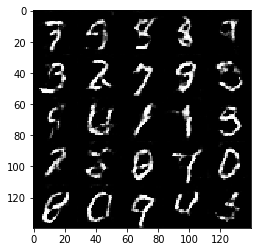

Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 0.3827
Epoch 1/2... Discriminator Loss: 1.2775... Generator Loss: 0.4817
Epoch 1/2... Discriminator Loss: 1.7838... Generator Loss: 0.2497
Epoch 2/2... Discriminator Loss: 1.7473... Generator Loss: 0.2463
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 1.1313
Epoch 2/2... Discriminator Loss: 1.4844... Generator Loss: 0.3428
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 0.4295
Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 1.0294
Epoch 2/2... Discriminator Loss: 1.3882... Generator Loss: 0.4633
Epoch 2/2... Discriminator Loss: 1.4025... Generator Loss: 0.9768


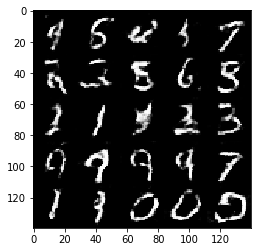

Epoch 2/2... Discriminator Loss: 1.0853... Generator Loss: 0.6908
Epoch 2/2... Discriminator Loss: 1.3499... Generator Loss: 0.3982
Epoch 2/2... Discriminator Loss: 1.8379... Generator Loss: 0.2224
Epoch 2/2... Discriminator Loss: 1.5134... Generator Loss: 1.5377
Epoch 2/2... Discriminator Loss: 1.2696... Generator Loss: 0.6507
Epoch 2/2... Discriminator Loss: 1.2625... Generator Loss: 0.4995
Epoch 2/2... Discriminator Loss: 1.2725... Generator Loss: 0.5029
Epoch 2/2... Discriminator Loss: 1.4216... Generator Loss: 0.3635
Epoch 2/2... Discriminator Loss: 2.0517... Generator Loss: 1.6319
Epoch 2/2... Discriminator Loss: 1.4129... Generator Loss: 0.4159


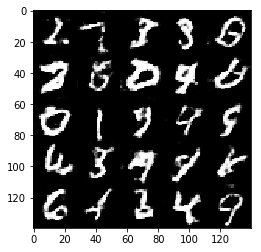

Epoch 2/2... Discriminator Loss: 1.0379... Generator Loss: 0.7853
Epoch 2/2... Discriminator Loss: 0.9891... Generator Loss: 0.6674
Epoch 2/2... Discriminator Loss: 1.0276... Generator Loss: 0.9077
Epoch 2/2... Discriminator Loss: 1.6092... Generator Loss: 0.3879
Epoch 2/2... Discriminator Loss: 1.2288... Generator Loss: 0.5220
Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 0.4197
Epoch 2/2... Discriminator Loss: 1.3072... Generator Loss: 0.4677
Epoch 2/2... Discriminator Loss: 1.2289... Generator Loss: 0.4447
Epoch 2/2... Discriminator Loss: 1.6122... Generator Loss: 0.2976
Epoch 2/2... Discriminator Loss: 1.5806... Generator Loss: 0.3485


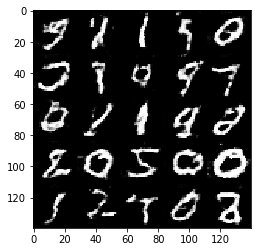

Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 0.5295
Epoch 2/2... Discriminator Loss: 1.2070... Generator Loss: 0.8000
Epoch 2/2... Discriminator Loss: 1.2245... Generator Loss: 0.5039
Epoch 2/2... Discriminator Loss: 1.2481... Generator Loss: 0.4588
Epoch 2/2... Discriminator Loss: 1.7192... Generator Loss: 0.2532
Epoch 2/2... Discriminator Loss: 1.7682... Generator Loss: 0.2304
Epoch 2/2... Discriminator Loss: 1.1587... Generator Loss: 1.0139
Epoch 2/2... Discriminator Loss: 1.3162... Generator Loss: 0.4294
Epoch 2/2... Discriminator Loss: 1.2054... Generator Loss: 0.6242
Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 0.4217


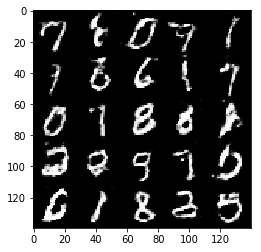

Epoch 2/2... Discriminator Loss: 1.0854... Generator Loss: 0.9213
Epoch 2/2... Discriminator Loss: 1.2711... Generator Loss: 0.4375
Epoch 2/2... Discriminator Loss: 1.0306... Generator Loss: 0.6759
Epoch 2/2... Discriminator Loss: 1.1991... Generator Loss: 0.5724
Epoch 2/2... Discriminator Loss: 1.2753... Generator Loss: 0.5369
Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 0.4524
Epoch 2/2... Discriminator Loss: 0.9927... Generator Loss: 0.7189
Epoch 2/2... Discriminator Loss: 1.6865... Generator Loss: 0.2805
Epoch 2/2... Discriminator Loss: 1.0615... Generator Loss: 0.7155
Epoch 2/2... Discriminator Loss: 1.3236... Generator Loss: 0.4365


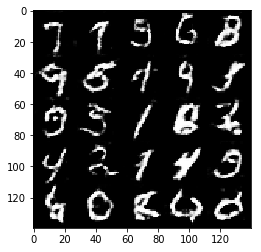

Epoch 2/2... Discriminator Loss: 1.1998... Generator Loss: 0.5247
Epoch 2/2... Discriminator Loss: 1.3195... Generator Loss: 0.5063
Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 0.5091
Epoch 2/2... Discriminator Loss: 1.3024... Generator Loss: 0.4308
Epoch 2/2... Discriminator Loss: 1.0430... Generator Loss: 0.8714
Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 1.1842
Epoch 2/2... Discriminator Loss: 0.8556... Generator Loss: 0.9753
Epoch 2/2... Discriminator Loss: 1.1941... Generator Loss: 0.5826
Epoch 2/2... Discriminator Loss: 1.1362... Generator Loss: 0.6193
Epoch 2/2... Discriminator Loss: 1.4819... Generator Loss: 0.3538


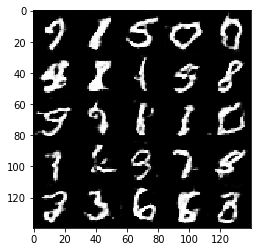

Epoch 2/2... Discriminator Loss: 1.5701... Generator Loss: 0.3125
Epoch 2/2... Discriminator Loss: 1.4203... Generator Loss: 0.3700
Epoch 2/2... Discriminator Loss: 1.4137... Generator Loss: 0.3812
Epoch 2/2... Discriminator Loss: 2.1175... Generator Loss: 0.1694
Epoch 2/2... Discriminator Loss: 1.1610... Generator Loss: 0.5306
Epoch 2/2... Discriminator Loss: 1.2028... Generator Loss: 0.5117
Epoch 2/2... Discriminator Loss: 1.3801... Generator Loss: 0.4336
Epoch 2/2... Discriminator Loss: 1.3038... Generator Loss: 0.4300
Epoch 2/2... Discriminator Loss: 1.2701... Generator Loss: 1.6784
Epoch 2/2... Discriminator Loss: 0.9775... Generator Loss: 0.7439


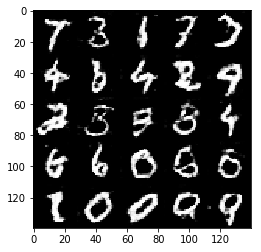

Epoch 2/2... Discriminator Loss: 1.3014... Generator Loss: 0.4512
Epoch 2/2... Discriminator Loss: 1.6165... Generator Loss: 0.3163
Epoch 2/2... Discriminator Loss: 1.1162... Generator Loss: 0.6156
Epoch 2/2... Discriminator Loss: 1.9916... Generator Loss: 0.1842
Epoch 2/2... Discriminator Loss: 1.3775... Generator Loss: 0.4353
Epoch 2/2... Discriminator Loss: 1.5169... Generator Loss: 0.3356
Epoch 2/2... Discriminator Loss: 1.4249... Generator Loss: 0.3811
Epoch 2/2... Discriminator Loss: 1.0796... Generator Loss: 1.4816
Epoch 2/2... Discriminator Loss: 0.9749... Generator Loss: 0.8621
Epoch 2/2... Discriminator Loss: 1.0026... Generator Loss: 0.9416


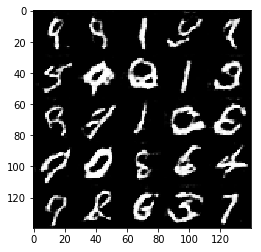

Epoch 2/2... Discriminator Loss: 1.4309... Generator Loss: 0.3771
Epoch 2/2... Discriminator Loss: 1.1711... Generator Loss: 0.5125
Epoch 2/2... Discriminator Loss: 1.5377... Generator Loss: 0.3158
Epoch 2/2... Discriminator Loss: 0.7629... Generator Loss: 1.1400
Epoch 2/2... Discriminator Loss: 1.3466... Generator Loss: 0.3769
Epoch 2/2... Discriminator Loss: 1.3771... Generator Loss: 0.4067
Epoch 2/2... Discriminator Loss: 1.0422... Generator Loss: 0.6824
Epoch 2/2... Discriminator Loss: 1.2542... Generator Loss: 0.4297
Epoch 2/2... Discriminator Loss: 1.0566... Generator Loss: 0.5833
Epoch 2/2... Discriminator Loss: 1.4525... Generator Loss: 0.3550


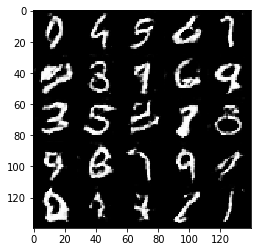

Epoch 2/2... Discriminator Loss: 1.1069... Generator Loss: 0.5881
Epoch 2/2... Discriminator Loss: 1.2277... Generator Loss: 0.4715
Epoch 2/2... Discriminator Loss: 0.9101... Generator Loss: 0.7367
Epoch 2/2... Discriminator Loss: 1.6076... Generator Loss: 3.1153
Epoch 2/2... Discriminator Loss: 1.0498... Generator Loss: 0.6442
Epoch 2/2... Discriminator Loss: 1.3129... Generator Loss: 0.4268
Epoch 2/2... Discriminator Loss: 1.9005... Generator Loss: 0.2143


In [12]:
batch_size = 64
z_dim = 100
learning_rate = .0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.1181... Generator Loss: 0.1232
Epoch 1/1... Discriminator Loss: 4.1725... Generator Loss: 0.0192
Epoch 1/1... Discriminator Loss: 2.4901... Generator Loss: 0.1447
Epoch 1/1... Discriminator Loss: 2.2638... Generator Loss: 0.2019
Epoch 1/1... Discriminator Loss: 2.3182... Generator Loss: 0.1770
Epoch 1/1... Discriminator Loss: 2.0069... Generator Loss: 0.2463
Epoch 1/1... Discriminator Loss: 1.9618... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.8436... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.8529... Generator Loss: 0.3162
Epoch 1/1... Discriminator Loss: 1.7922... Generator Loss: 0.7995


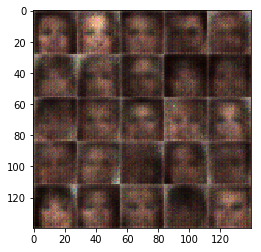

Epoch 1/1... Discriminator Loss: 1.5717... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.6614... Generator Loss: 0.5002
Epoch 1/1... Discriminator Loss: 1.6130... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.6585... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.6753... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 1.6208... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.5968... Generator Loss: 0.5324
Epoch 1/1... Discriminator Loss: 1.6144... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.5184
Epoch 1/1... Discriminator Loss: 1.6186... Generator Loss: 0.5347


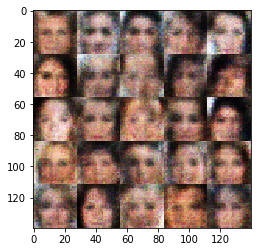

Epoch 1/1... Discriminator Loss: 1.5765... Generator Loss: 0.5299
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.5345... Generator Loss: 0.4801
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.5689... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.4926
Epoch 1/1... Discriminator Loss: 1.7923... Generator Loss: 0.2910
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.4880


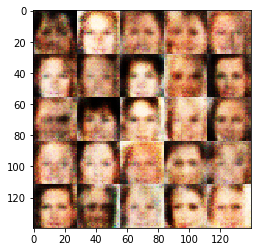

Epoch 1/1... Discriminator Loss: 1.7197... Generator Loss: 0.3505
Epoch 1/1... Discriminator Loss: 1.6429... Generator Loss: 0.3930
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.7190... Generator Loss: 0.3559
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.5044
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.7272... Generator Loss: 0.3098
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 1.7154... Generator Loss: 0.2962


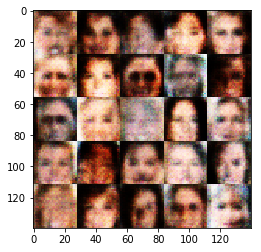

Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 1.3653
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 1.9607
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.0433
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 1.6866
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.2950
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.7064
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 1.3163


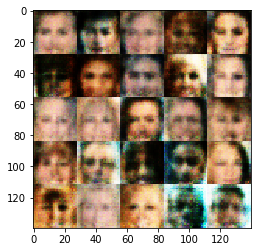

Epoch 1/1... Discriminator Loss: 1.6453... Generator Loss: 0.3158
Epoch 1/1... Discriminator Loss: 1.6535... Generator Loss: 0.2891
Epoch 1/1... Discriminator Loss: 1.5794... Generator Loss: 0.3805
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.5334
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.6511... Generator Loss: 0.3202
Epoch 1/1... Discriminator Loss: 1.5926... Generator Loss: 0.3435


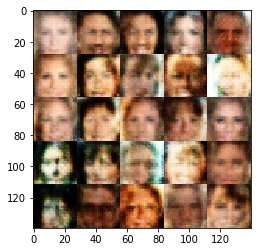

Epoch 1/1... Discriminator Loss: 1.5732... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 1.3237
Epoch 1/1... Discriminator Loss: 1.6066... Generator Loss: 0.4091
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.7210... Generator Loss: 0.3317
Epoch 1/1... Discriminator Loss: 1.7397... Generator Loss: 0.2622
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.7847


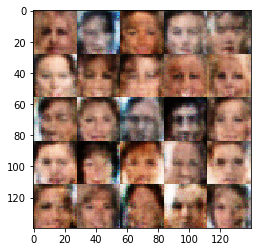

Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.5620... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 1.5976... Generator Loss: 0.4128
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.6159... Generator Loss: 0.4311
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.6583


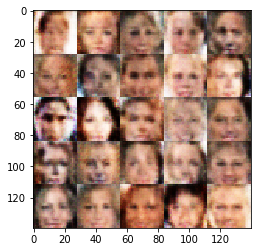

Epoch 1/1... Discriminator Loss: 1.5524... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.6515... Generator Loss: 0.3641
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.5748... Generator Loss: 0.4784
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.5688... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.5471... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.5424


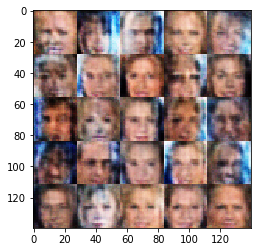

Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6752


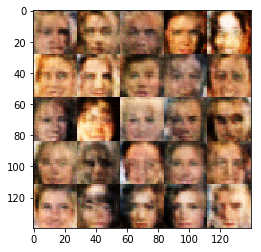

Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6784


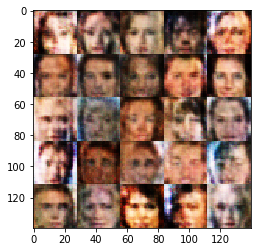

Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.5886


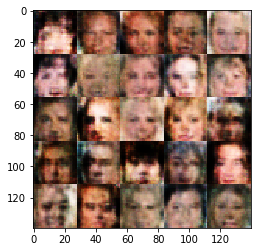

Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6784


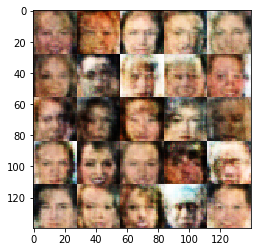

Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6520


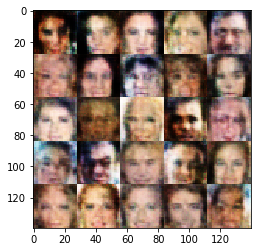

Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6411


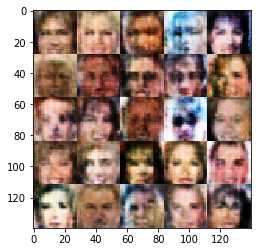

Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.6319


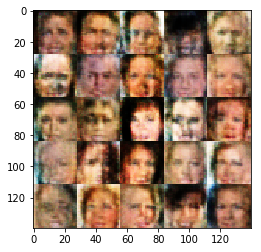

Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.6171


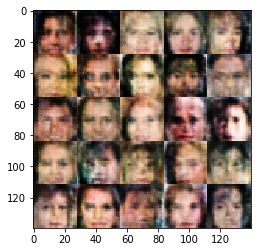

Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.5826
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6818


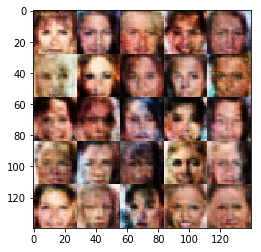

Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.6413


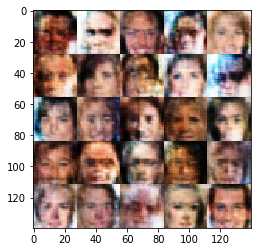

Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.6611


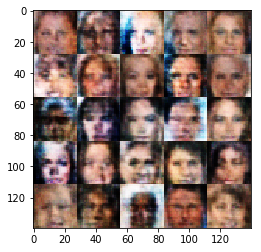

Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.6436


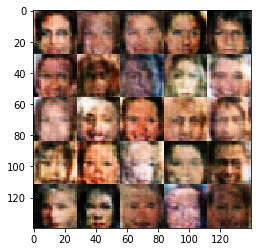

Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6706


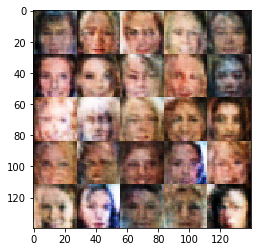

Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6456


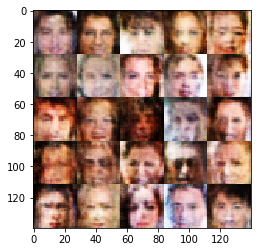

Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.6429


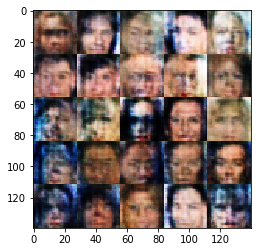

Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.6255


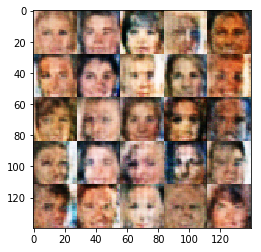

Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.6877


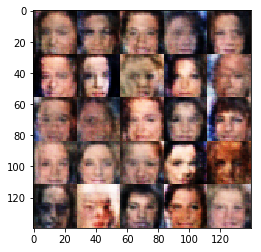

Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.6564


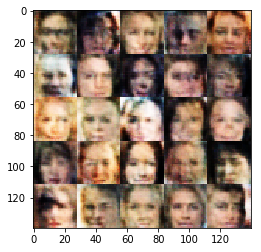

Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.6375


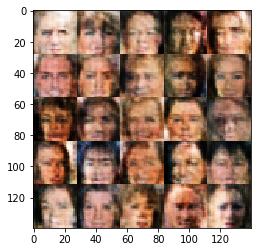

Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.6607


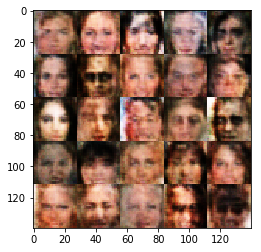

Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.6448


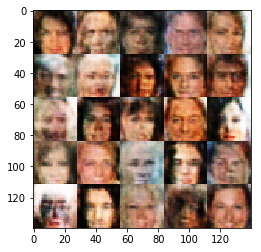

Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.6444


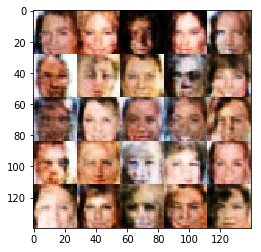

Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.6503... Generator Loss: 0.4696
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6631


In [13]:
batch_size = 64
z_dim = 100
learning_rate = .0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.